In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import pandas as pd
import scipy.io
import seaborn as sns
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
import h5py

In [2]:
f = h5py.File('LocustDemoData.hdf5', 'r')
dset = f['1']
data_shape = dset.shape
data_len = data_shape[0]

data = [np.empty(data_shape,dtype=np.float64) for i in range(4)]
for i in range(4):
    dset = f[str(i+1)]
    dset.read_direct(data[i])



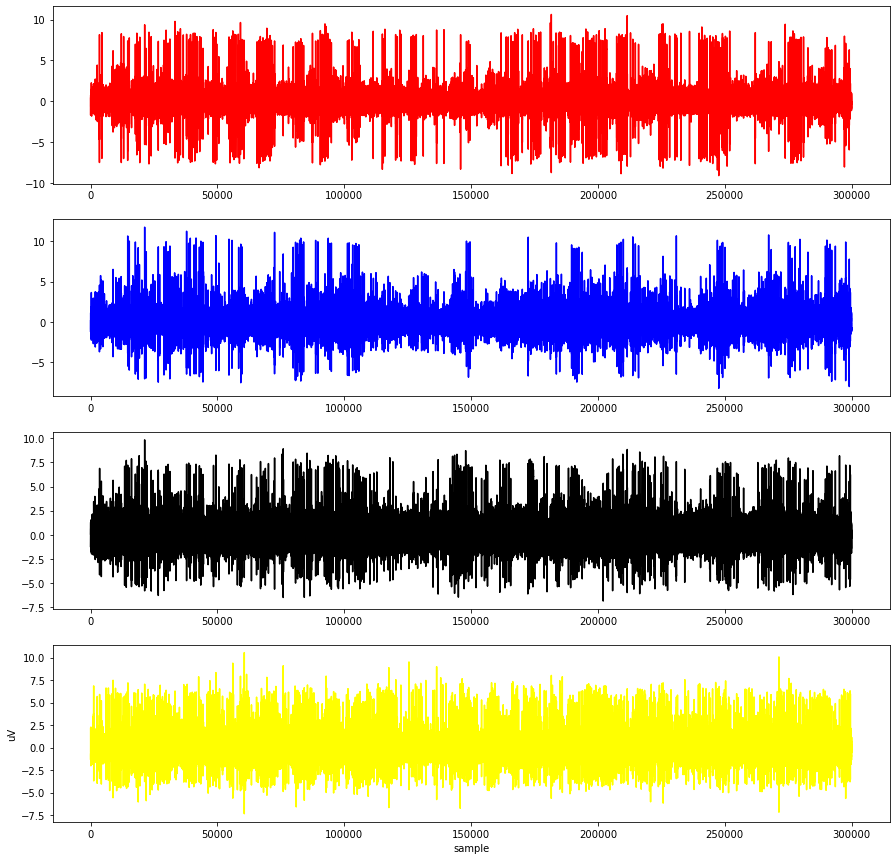

In [3]:
fig, axs = plt.subplots(4,1,figsize=(15,15))
Color=['red','blue','black','yellow']
for i in range(4):
    axs[i].plot(data[i],color=Color[i])
    plt.xlabel('sample')
    plt.ylabel('uV')
    
    

In [4]:
Ch=np.zeros((4,300000))

In [5]:
for n in range(4):
    Ch[n]=np.copy(data[n])

In [6]:
from scipy.signal import butter, lfilter

def butter_bandpass_filter(signal, lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq

    b, a = butter(order, [low, high], btype='band')
    y = lfilter(b, a, signal)
    return y


[]

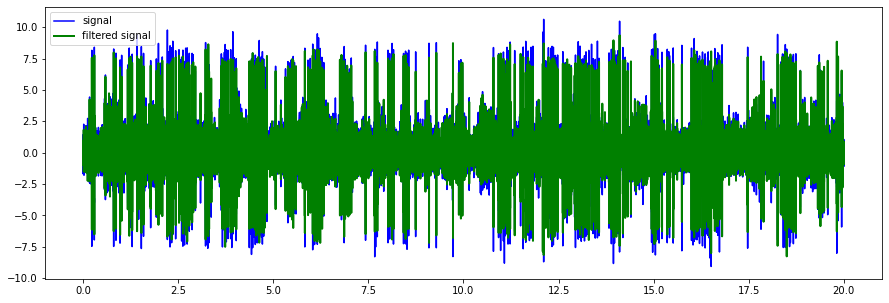

In [7]:
time = np.arange(0,data_len)/1.5e4
low_cut=300
high_cut=5000
sampling_freq=15000
filtered_signal=butter_bandpass_filter(signal=Ch[0], lowcut=low_cut, highcut=high_cut, fs=sampling_freq, order=2)
fig, axs = plt.subplots(1,1,figsize=(15,5))
plt.plot(time, Ch[0], 'b-', label='signal')
plt.plot(time, filtered_signal, 'g-', linewidth=2, label='filtered signal')
plt.legend()
plt.plot()

In [8]:
sigma=np.median(abs(filtered_signal))/0.6745

In [9]:
Th=5*sigma

No handles with labels found to put in legend.


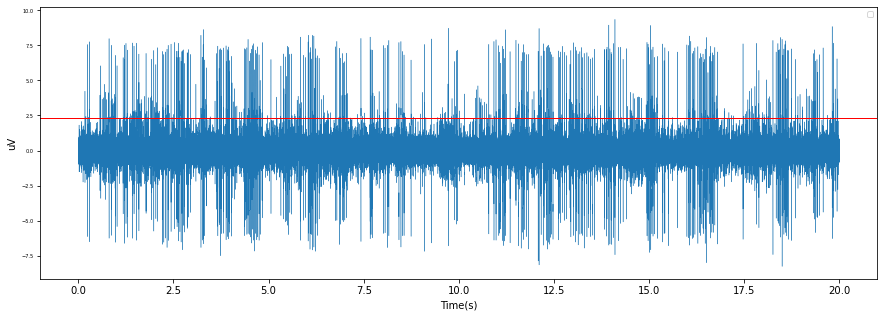

In [10]:
plt.figure(figsize=(15,5))
plt.plot(time,filtered_signal,linewidth=0.4)
plt.yticks(fontsize=5)
plt.xlabel('Time(s)')
plt.ylabel('uV')
plt.axhline(Th,color='red',linewidth=1)
plt.legend(fontsize=8,facecolor='w')
plt.grid(False)
plt.show()

In [11]:
spike=filtered_signal > Th

In [12]:
temp=filtered_signal
#temp < Th

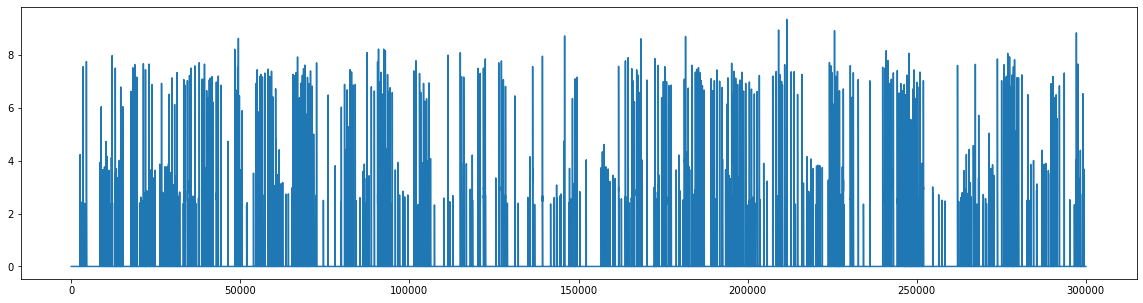

In [13]:
temp[temp < Th] = 0
plt.figure(figsize=(20,5))
plt.plot(temp)

In [14]:
#When the spike occurs and refractory period condition
peaks=scipy.signal.find_peaks(temp,distance=100)

In [15]:
idx_spike=peaks[0]
spike=temp[peaks[0]]
num_spike=len(peaks[0])

In [16]:
num_sample_forward=50
num_sample_backward=30
Ch1=np.copy(Ch[0])

In [17]:
spike_curve=np.zeros((num_spike,num_sample_forward+num_sample_backward))
for i in range(num_spike):
    spike_curve[i]=Ch1[(idx_spike[i]-num_sample_backward):idx_spike[i]+num_sample_forward] 

Text(0, 0.5, 'uV')

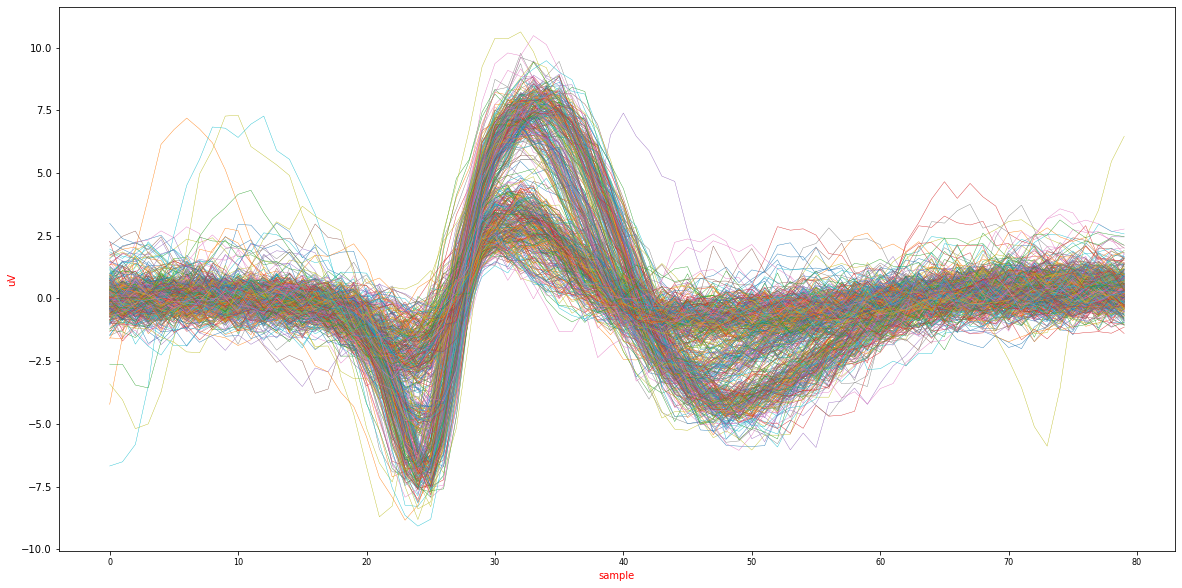

In [18]:
plt.figure(figsize=(20,10))
for i in range(num_spike):
    plt.plot(spike_curve[i],linewidth=0.4)
plt.xticks(fontsize=8)
plt.xlabel('sample',color='red')
plt.ylabel('uV',color='red')

In [19]:
spike_feature=np.zeros((num_spike,2))
for i in range(num_spike):
    spike_feature[i,0]=min(spike_curve[i])
    spike_feature[i,1]=max(spike_curve[i])
  

In [20]:
spike_data =spike_feature.copy()
spike_data1=spike_feature.copy()
spike_data2=spike_feature.copy()
spike_data3=spike_feature.copy()

Text(0, 0.5, 'pos ampliude')

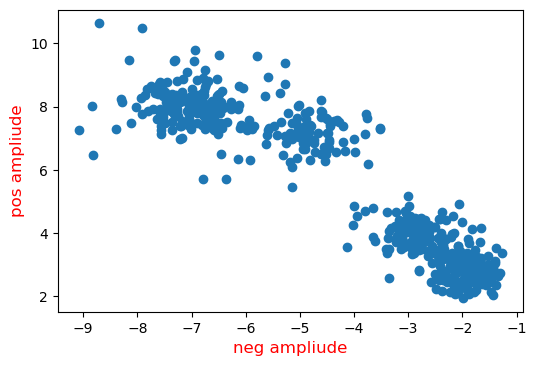

In [21]:
plt.figure(dpi=100)
plt.scatter(spike_feature[:,0],spike_feature[:,1])
plt.xlabel('neg ampliude',color='red',fontsize=12)
plt.ylabel('pos ampliude',color='red',fontsize=12)

In [22]:
from sklearn.cluster import KMeans
error_kmeans=[]
b=np.arange(2,6)
for i in b:
    km = KMeans(n_clusters=i).fit(spike_feature)
    km_labels=km.predict(spike_feature)
    error_kmeans.append(silhouette_score(spike_feature,km.labels_))

In [23]:
from sklearn.mixture import GaussianMixture
error_MG = []
b=np.arange(2,6)
for i in b:
    gmm_model = GaussianMixture(n_components=i).fit(spike_data1)
    MG_labels = gmm_model.predict(spike_data1)
    error_MG.append(silhouette_score(spike_data1,MG_labels))

In [24]:
from sklearn.cluster import SpectralClustering
error_SP = []
b=np.arange(2,6)
for i in b:
    sp = SpectralClustering(n_clusters=i)
    sp_labels = sp.fit_predict(spike_data2)
    error_SP.append(silhouette_score(spike_data2,sp_labels))

In [25]:
from sklearn.cluster import DBSCAN
error_DB = []
b=np.arange(2,6)
for i in b:
    dbscan = DBSCAN(eps =i*0.25).fit(spike_data3)
    db_labels=dbscan.fit_predict(spike_data3)
    error_DB.append(silhouette_score(spike_data3,db_labels))

[]

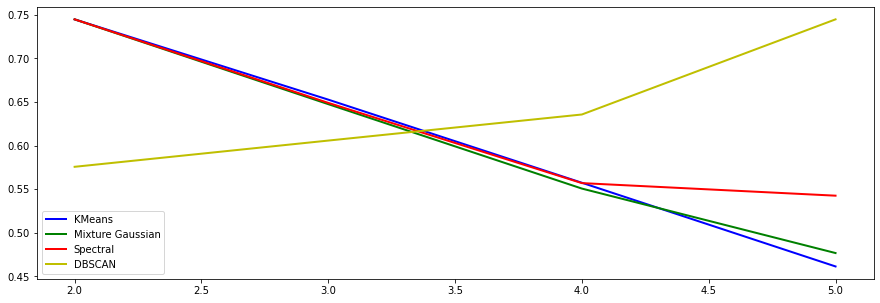

In [26]:
cluster=np.arange(2,6)
fig, axs = plt.subplots(1,1,figsize=(15,5))
plt.plot(cluster, error_kmeans, 'b-',linewidth=2, label='KMeans')
plt.plot(cluster, error_MG, 'g-', linewidth=2, label='Mixture Gaussian')
plt.plot(cluster, error_SP, 'r-', linewidth=2, label='Spectral')
plt.plot(cluster, error_DB, 'y-', linewidth=2, label='DBSCAN')
plt.legend()
plt.plot()

In [27]:
km = KMeans(n_clusters=3).fit(spike_feature)
km_labels=km.predict(spike_feature)
gmm_model = GaussianMixture(n_components=4).fit(spike_data1)
MG_labels = gmm_model.predict(spike_data1)
sp = SpectralClustering(n_clusters=3)
sp_labels = sp.fit_predict(spike_data2)
dbscan = DBSCAN(eps =1).fit(spike_data3)
db_labels=dbscan.fit_predict(spike_data3)

Text(0.5, 0, 'Spectral')

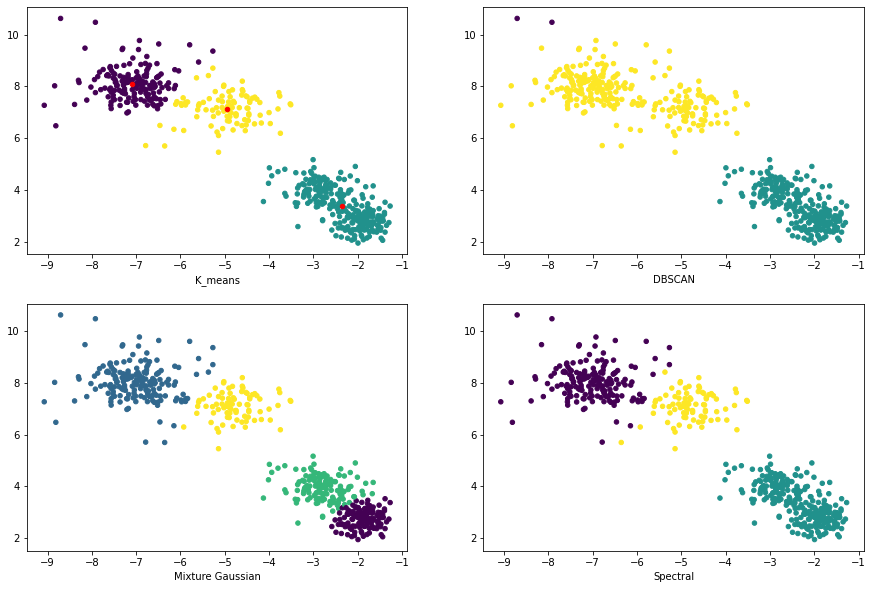

In [28]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0,0].scatter(spike_feature[:,0],spike_feature[:,1],c=km_labels,s=20,edgecolors='face')
axs[0,0].set_xlabel('K_means')
centroids = km.cluster_centers_
axs[0,0].scatter(centroids[:,0],centroids[:,1],c='r',s=20,edgecolors='face')
axs[0,1].scatter(spike_data[:,0],spike_data[:,1],c=db_labels,s=20,edgecolors='face')
axs[0,1].set_xlabel('DBSCAN')
axs[1,0].scatter(spike_data1[:,0],spike_data1[:,1],c=MG_labels,s=20,edgecolors='face')
axs[1,0].set_xlabel('Mixture Gaussian')
axs[1,1].scatter(spike_data2[:,0],spike_data2[:,1],c=sp_labels,s=20,edgecolors='face')
axs[1,1].set_xlabel('Spectral')

In [29]:
neuron1=np.zeros(spike_curve.shape)
neuron2=np.zeros(spike_curve.shape)
neuron3=np.zeros(spike_curve.shape)
neuron4=np.zeros(spike_curve.shape)


In [30]:
neuron1=np.zeros(spike_curve.shape)
neuron2=np.zeros(spike_curve.shape)
neuron3=np.zeros(spike_curve.shape)
neuron4=np.zeros(spike_curve.shape)
N1=0
N2=0
N3=0
N4=0
for i in range(len(MG_labels)):
    if (MG_labels[i]==0):
            neuron1[i] = spike_curve[i]
            N1=N1+1
    if (MG_labels[i]==1):
             neuron2[i] =spike_curve[i]
             N2=N2+1
    if (MG_labels[i]==2):
             neuron3[i] =spike_curve[i]
             N3=N3+1
    if (MG_labels[i]==3):
            neuron4[i] = spike_curve[i]
            N4=N4+1
    

In [31]:
print('Neuron1 spikes:',N1)
print('Neuron2 spikes:',N2)
print('Neuron3 spikes:',N3)
print('Neuron3 spikes:',N4)

Neuron1 spikes: 127
Neuron2 spikes: 178
Neuron3 spikes: 135
Neuron3 spikes: 80


Text(0.5, 0, 'NEURON4')

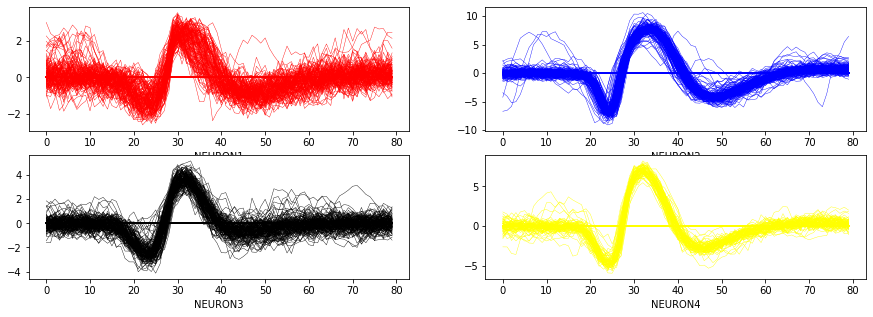

In [32]:
fig, axs = plt.subplots(2,2,figsize=(15,5))
for i in range(num_spike):
    axs[0,0].plot(neuron1[i],linewidth=0.4,color='red')
axs[0,0].set_xlabel('NEURON1')
for i in range(num_spike):
    axs[0,1].plot(neuron2[i],linewidth=0.4,color='blue')
axs[0,1].set_xlabel('NEURON2')
for i in range(num_spike):
    axs[1,0].plot(neuron3[i],linewidth=0.4,color='black')
axs[1,0].set_xlabel('NEURON3')
for i in range(num_spike):
    axs[1,1].plot(neuron4[i],linewidth=0.4,color='yellow')
axs[1,1].set_xlabel('NEURON4')

In [33]:
pca = PCA(n_components=80)
principalComponents = pca.fit_transform(spike_curve)

In [34]:
eigen=principalComponents[:80,:]

In [35]:
spike_feature1=np.dot(spike_curve,(eigen))

Text(0, 0.5, 'pos ampliude')

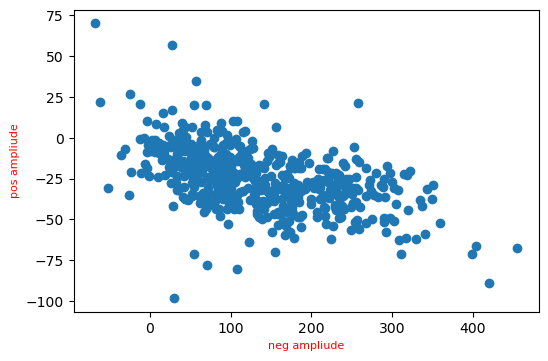

In [36]:
plt.figure(dpi=100)
plt.scatter(spike_feature1[:,0],spike_feature1[:,1])
plt.xlabel('neg ampliude',color='red',fontsize=8)
plt.ylabel('pos ampliude',color='red',fontsize=8)

In [37]:
new_km = KMeans(2)
PC = new_km.fit(spike_feature1)
kmeans_pca=PC.predict(spike_feature1)

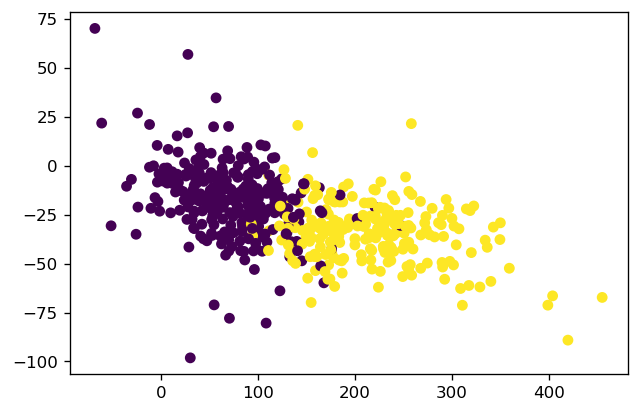

In [38]:
plt.figure(dpi=120)
plt.scatter(spike_feature1[:,0],spike_feature1[:,1],c=kmeans_pca,s=30,edgecolors='face')

In [39]:
x=np.arange(0,81)
model1=[]
for i in x:
    model1.append(neuron1[:,i-1].mean())

In [40]:
model2=[]
for i in x:
    model2.append(neuron2[:,i-1].mean())

In [41]:
model3=[]
for i in x:
    model3.append(neuron3[:,i-1].mean())

In [42]:
model4=[]
for i in x:
    model4.append(neuron4[:,i-1].mean())

In [43]:
np.shape(model3)

(81,)

Text(0.5, 0, 'model4')

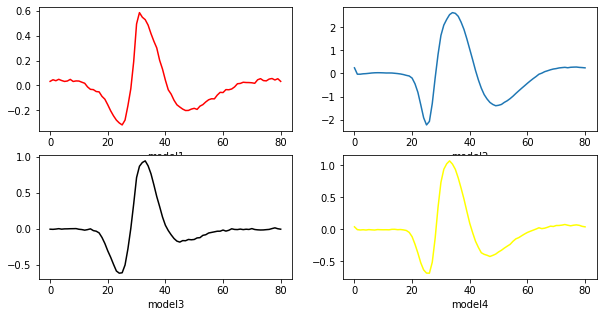

In [44]:
fig, axs = plt.subplots(2,2,figsize=(10,5))
axs[0,0].plot(model1,color='red')
axs[0,0].set_xlabel('model1')
axs[0,1].plot(model2)
axs[0,1].set_xlabel('model2')
axs[1,0].plot(model3,color='black')
axs[1,0].set_xlabel('model3')
axs[1,1].plot(model4,color='yellow')
axs[1,1].set_xlabel('model4')

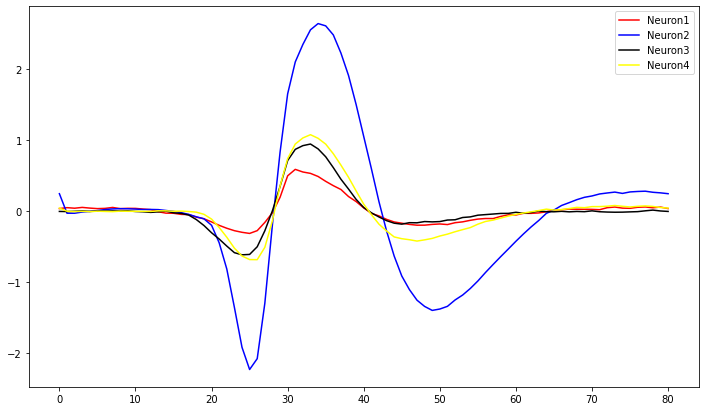

In [47]:
plt.figure(figsize=(12,7))
plt.plot(model1,color='red',label='Neuron1')
plt.plot(model2,color='blue',label='Neuron2')
plt.plot(model3,color='black',label='Neuron3')
plt.plot(model4,color='yellow',label='Neuron4')
plt.legend()